In [88]:
!pip  install wordcloud

In [89]:
import pandas as pd
import numpy as np
import string
import re
import nltk
import sklearn
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve,auc

In [90]:
headers = ["ID","label","statement","subjects(s)","speaker","speaker_job","state_info","affilation","barely_true_counts","false_counts","half_true_counts","mostly_true_counts","pants_on_fire_counts","context"]

In [91]:
train = pd.read_csv("train.tsv",sep = "\t",header = None,names=headers)
test  = pd.read_csv("test.tsv",sep = "\t",header = None,names = headers)
valid = pd.read_csv("valid.tsv",sep = "\t",header = None,names = headers) 


In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    10240 non-null  object 
 1   label                 10240 non-null  object 
 2   statement             10240 non-null  object 
 3   subjects(s)           10238 non-null  object 
 4   speaker               10238 non-null  object 
 5   speaker_job           7342 non-null   object 
 6   state_info            8030 non-null   object 
 7   affilation            10238 non-null  object 
 8   barely_true_counts    10238 non-null  float64
 9   false_counts          10238 non-null  float64
 10  half_true_counts      10238 non-null  float64
 11  mostly_true_counts    10238 non-null  float64
 12  pants_on_fire_counts  10238 non-null  float64
 13  context               10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [93]:
train.describe()

,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts
count,10238.000000,10238.000000,10238.000000,10238.000000,10238.000000
mean,11.533210,13.286482,17.133718,16.434265,6.201407
std,18.973764,24.112936,35.846511,36.151688,16.128927
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,12.000000,13.000000,11.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


In [94]:

train['label'] = train['label'].replace({
    'false':'fake',
    'half-true':'real',
    'mostly-true':'real',
    'true':'real',
    'barely-true':'real',
    'pants-fire':'fake'
})
valid['label'] = valid['label'].replace({
    'false':'fake',
    'half-true':'real',
    'mostly-true':'real',
    'true':'real',
    'barely-true':'real',
    'pants-fire':'fake'
})
test['label'] = test['label'].replace({
    'false':'fake',
    'half-true':'real',
    'mostly-true':'real',
    'true':'real',
    'barely-true':'real',
    'pants-fire':'fake'
})
valid['label'].unique()

array(['real', 'fake'], dtype=object)

In [95]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maana\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [96]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [97]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+','',text)
    text = re.sub(r'[^a-z\s]','',text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)


In [98]:
train['cleaned_statement'] = train['statement'].apply(clean_text)
valid['cleaned_statement'] = valid['statement'].apply(clean_text)
test['cleaned_statement'] = test['statement'].apply(clean_text)

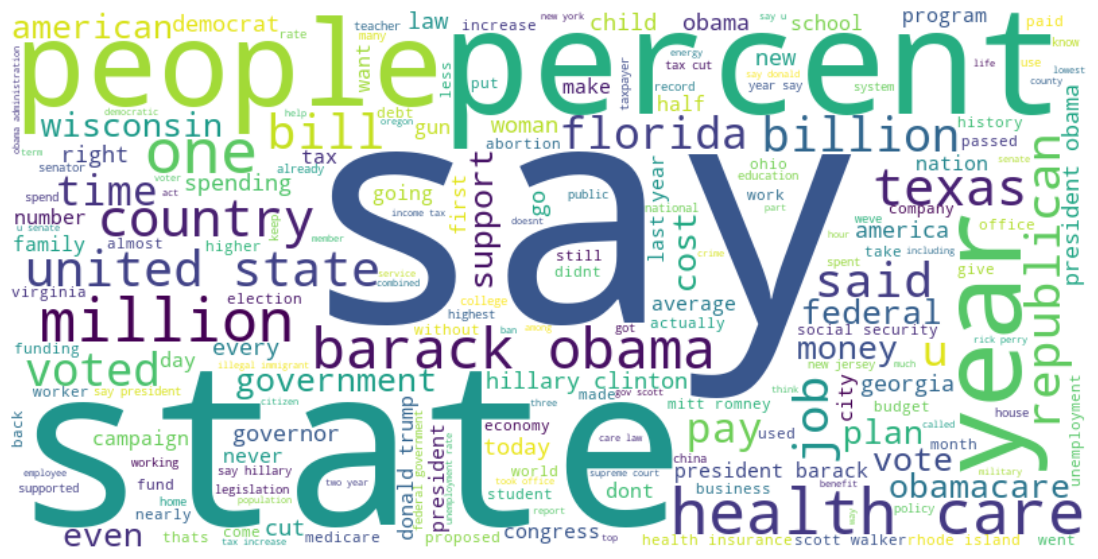

In [99]:
text = ' '.join(train['cleaned_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [100]:
vectorizer = TfidfVectorizer(max_features=5000)
x_train = vectorizer.fit_transform(train["cleaned_statement"])
x_valid = vectorizer.transform(valid["cleaned_statement"])
x_test = vectorizer.transform(test["cleaned_statement"])
# dense_matrix = x_test.toarray()
# print(dense_matrix)

In [101]:
le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_valid = le.transform(valid['label'])
y_test = le.transform(valid['label'])


In [102]:
model = LogisticRegression(max_iter=1000)
model.fit(x_train,y_train)
y_pred = model.predict(x_valid)


In [107]:
print("Accuracy:", accuracy_score(y_valid,y_pred))
report = classification_report(y_valid, y_pred, target_names=le.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)
print("Confusion matrix:",confusion_matrix(y_valid,y_pred))

Accuracy: 0.7040498442367601
              precision    recall  f1-score     support
fake           0.492308  0.084433  0.144144   379.00000
real           0.715340  0.963536  0.821092   905.00000
accuracy       0.704050  0.704050  0.704050     0.70405
macro avg      0.603824  0.523984  0.482618  1284.00000
weighted avg   0.649508  0.704050  0.621277  1284.00000
Confusion matrix: [[ 32 347]
 [ 33 872]]


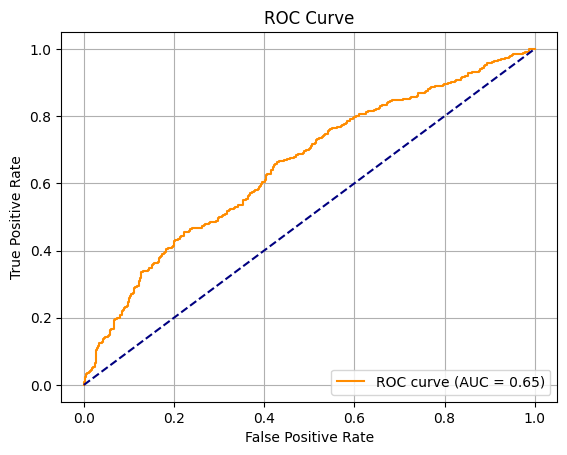

In [104]:
from sklearn.metrics import roc_curve, auc

y_probs = model.predict_proba(x_valid)[:, 1]  # Get probability for class 1
fpr, tpr, _  = roc_curve(y_valid, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


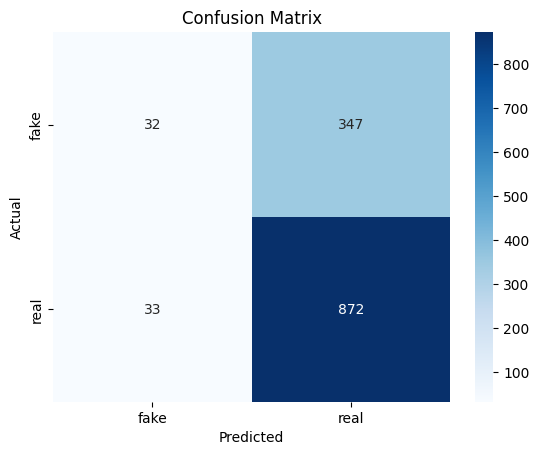

In [105]:
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()